# Recurrent Neural Networks (RNN)



In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Importing keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
np.random.seed(7)

In [119]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [120]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [122]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [123]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [124]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [126]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [129]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:26<00:00, 2491.20it/s]


In [0]:
final['CleanedText']=preprocessed_reviews

## [2] Data Preparation

In [191]:
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...


In [0]:
X = data['CleanedText'].values
y = data['Score']

In [173]:
#Vocabulary
count_vect = CountVectorizer() 
count_vect.fit(X)

vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  116756


In [0]:
#Creating dictionary
corpus = dict()
ind = 0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

#Frequency for each word of vocabulary
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))

In [0]:
#Frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

#Allocating ranks 
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [0]:
data = []
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

#Splitting the data 
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(data, y, test_size=0.3, random_state=42)

## [3] Recurrent Neural Networks(RNN) with one LSTM layer

In [177]:
#padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(254919, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    43    36    21    17   425   281   272   141     4   308
   304    89  4220   134  1306  1380   137     8   166    80   272   179
  1380    21    68   141  6207   182   276    66    96   285    56   396
  3271    85   406   304   727   134     2  4097 12684   436     1  4220
   132   304  8709   973     2  4513  3051   212  1773   123   336    16
   302  1380   272   179]


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

In [179]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
epochs = 10

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 32)           3736224   
_________________________________________________________________
dropout_23 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 3,789,525
Trainable params: 3,789,525
Non-trainable params: 0
_________________________________________________________________
None


In [180]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

Train on 254919 samples, validate on 109252 samples
Epoch 1/10
254919/254919 [==============================] - 541s 2ms/step - loss: 0.2359 - acc: 0.9087 - val_loss: 0.1891 - val_acc: 0.9255
Epoch 2/10
254919/254919 [==============================] - 537s 2ms/step - loss: 0.1622 - acc: 0.9378 - val_loss: 0.1807 - val_acc: 0.9287
Epoch 3/10
254919/254919 [==============================] - 536s 2ms/step - loss: 0.1410 - acc: 0.9464 - val_loss: 0.1814 - val_acc: 0.9291
Epoch 4/10
254919/254919 [==============================] - 539s 2ms/step - loss: 0.1259 - acc: 0.9529 - val_loss: 0.1874 - val_acc: 0.9269
Epoch 5/10
254919/254919 [==============================] - 540s 2ms/step - loss: 0.1130 - acc: 0.9583 - val_loss: 0.1964 - val_acc: 0.9287
Epoch 6/10
254919/254919 [==============================] - 540s 2ms/step - loss: 0.1015 - acc: 0.9627 - val_loss: 0.1993 - val_acc: 0.9280
Epoch 7/10
254919/254919 [==============================] - 536s 2ms/step - loss: 0.0927 - acc: 0.9665 - val

Test score: 0.2540366640108507
Test accuracy: 0.9279921649031597


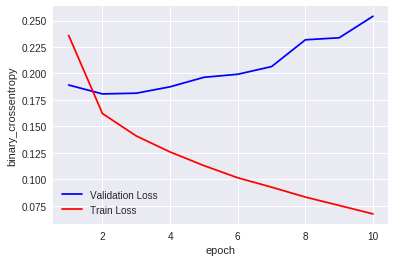

In [182]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## [4] Recurrent Neural Networks(RNN) with two LSTM layer

In [183]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
epochs = 10

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 32)           3736224   
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 100)          53200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 3,869,925
Trainable params: 3,869,925
Non-trainable params: 0
_________________________________________________________________
None


In [184]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fitting the data to the model
history = model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=512 ,verbose=1,validation_data=(X_test, Y_test))

Train on 254919 samples, validate on 109252 samples
Epoch 1/10
254919/254919 [==============================] - 1289s 5ms/step - loss: 0.2451 - acc: 0.9058 - val_loss: 0.1861 - val_acc: 0.9269
Epoch 2/10
254919/254919 [==============================] - 1282s 5ms/step - loss: 0.1711 - acc: 0.9345 - val_loss: 0.1842 - val_acc: 0.9296
Epoch 3/10
254919/254919 [==============================] - 1281s 5ms/step - loss: 0.1529 - acc: 0.9419 - val_loss: 0.1833 - val_acc: 0.9304
Epoch 4/10
254919/254919 [==============================] - 1282s 5ms/step - loss: 0.1393 - acc: 0.9475 - val_loss: 0.1784 - val_acc: 0.9307
Epoch 5/10
254919/254919 [==============================] - 1280s 5ms/step - loss: 0.1285 - acc: 0.9521 - val_loss: 0.1844 - val_acc: 0.9281
Epoch 6/10
254919/254919 [==============================] - 1279s 5ms/step - loss: 0.1187 - acc: 0.9560 - val_loss: 0.1837 - val_acc: 0.9321
Epoch 7/10
254919/254919 [==============================] - 1281s 5ms/step - loss: 0.1090 - acc: 0.959

Test score: 0.20112270053751743
Test accuracy: 0.9342529198550141


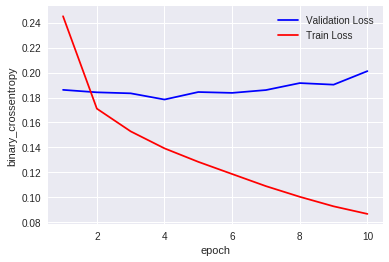

In [186]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [188]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["RNN_MODEL", "TRAIN_ACCURACY", "TEST_ACCURACY"]
x.add_row(["LSTM", 0.976, 0.928])
x.add_row(["LSTM(2-hidden layers)", 0.968, 0.934])

print('\t\tRNN WITH DIFFERNET ARCHITECTURES')
print(x)


		RNN WITH DIFFERNET ARCHITECTURES
+-----------------------+----------------+---------------+
|       RNN_MODEL       | TRAIN_ACCURACY | TEST_ACCURACY |
+-----------------------+----------------+---------------+
|          LSTM         |     0.976      |     0.928     |
| LSTM(2-hidden layers) |     0.968      |     0.934     |
+-----------------------+----------------+---------------+


## Conclusion


1.   After including more than one LSTM layers the test accuracy has increased
2.   Both the models are overfit

